# Mortgage Loan Amortisation and Rental Properties

This document is created from a Jupyter notebook which forms part of a series of studies into various personal finance and retirement planning topics.   The need for this work flowed from my need to obtain a better understanding of some simple but also some more complex scenarios that occur in personal finance management, and in particular, in planning for retirement.  In my experience brokers' advice is often focused on their product offering, not really considering their clients scenarios from a broader perspective.  The aim with this work is develop a broader perspective to support informed decision making.

This is a work in progress.

The Jupyter notebooks, [available here](https://github.com/NelisW/RetirementPlanning), use the Python language to calculate the outcomes of various alternatives scenarios.  
This work is fully open and transparant. You can download all my files, check my algorithms and repeat the calculations.  If I am incorrect somewhere, please advise.

The notebook format serves my needs, but to make the information available in PDF the notebooks are converted to \LaTeX{} and then to PDFs.  The \LaTeX{}/PDF output is a spin-off product, hence may not be a professionally polished product.

This notebook investigates various case studies involving mortgage bond loan repayments.  The initial studies are relatively simple, but then move on to investigate more complex scenarios with multiple bonds and rental property income.

In [79]:
# to prepare the Python environment
import os
import sys
import numpy as np
import pandas as pd
from datetime import date
from collections import OrderedDict
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from IPython.core.display import display, HTML
from IPython.display import Latex

persfin = os.path.join("./","persfin")
sys.path = [persfin]+sys.path

import fingenerators as fingen
import utilityfuns as ufun
import rentalfuns as rfun


# pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision',5)
pd.set_option('display.max_colwidth',100)
pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline
plt.style.use('ggplot')

doLaTeXdisplay = True

## Mortgage Bond Amortisation 

Terminology: 

A *mortgage* is a loan (usually secured by a bond) where the purpose of the loan is to purchase a fixed asset in the name of the borrower, but where the lender has the right to seize the asset if the borrower defaults on payment. The lender's right to seize falls away once the loan is fully repaid.

A *bond* is is a long term load agreement (by contract or certificate) whereby one party undertakes to repay the principal amount of the loan with interest by an agreed date. The term 'bond' is used in this document to imply a bond with a schedule of regular payments, usually monthly. In this notebook the terms bond and mortgage are use mostly equivalently.


The algorithm, model and code details are described  [here](https://github.com/NelisW/RetirementPlanning/blob/master/00-Programming.ipynb) in the `00-Programming` notebook.

Imagine an account that keeps track of all money flowing in and out on a monthly basis.  The account is iterated on monthly until some end condition is met.  This end condition can be a fixed term or until the bond is repaid (balance is zero).

The main inputs to the model are the following:

1. `principal`: Amount borrowed
1. `interest_rate`: The annual interest rate for this loan.
1. `bondyears`: Bond duration in the number of years for the loan.
1. `reqpayment`: Required payment (minimum) amount per period to repay the loan during the term.
1. `addpayment`: Initial value of additional payments (if any) to be made each period. The additional payment can be specified as a money value or as a fraction of the required payment. Complex value notation is used where the money value is the real component (e.g., -2300, negative value) and the fractional value is the imaginary component (e.g., .02j, positive fraction). If the (negative) real component (money value) is given the (positive) imaginary component (fraction value) is ignored. For a fractional value of 0.02j the additional payment is 0.02 * `reqpayment`.


1. `addpayrate`: Rate of increase in the  additional payment (can be zero), calculated once per year on January~1.
1. `start_date`: Start date for the loan. The start date is normally 2000-01-01.
1. `cyclesPerAnnum`: Number of payment cycles in a year, normally 12.


The model provides two outputs: 

1. A monthly schedule `df` that shows the values (account balance, interest, payments, etc.) for every month in the form of a Pandas DataFrame

1. The `stats` DataFrame provide a summary of the total contract, showing the key values, including the duration, required payment, additional payment (if provided) and the total interest over the full term of the contract.  

Note that the principal value is positive (inflow) and the payments and interest is negative (outflow).  
* When money is taken out from your pocket (outflows, you pay): use a negative sign.  
* When money is given to you (inflows, pay to you), use a positive sign.


### Simple example



Observe that although the bond is registered for 20 years, the loan is paid back early, because of the small additional payment. In this case the additioal payment stayed the same for the whole term.

In [47]:
# to calculate  a typical bond repayment case with a non-escalating 2% additional payment
principal = 1000000
interest_rate = 0.09
bondyears = 20
cyclesPerAnnum = 12
reqpayment = round(np.pmt(interest_rate/cyclesPerAnnum, bondyears*cyclesPerAnnum, principal), 2)

df, stats = fingen.amortisation_table(
    principal=principal, 
    interest_rate=interest_rate, 
    bondyears=bondyears, 
    reqpayment = reqpayment,
    addpayment = 0.02j,
    cyclesPerAnnum=cyclesPerAnnum, 
    start_date=date(2000, 1,1),
    addpayrate=0.0,
    ID=""
    )

if doLaTeXdisplay:
    display(Latex(stats.to_latex(index=True,column_format='|l|r|')))
else:
    display(HTML(stats.to_frame().to_html(index = True)))


<IPython.core.display.Latex object>

In [48]:
# to calculate  a typical bond repayment case with a 6% escalating 2% additional payment
principal = 1000000
interest_rate = 0.09
bondyears = 20
cyclesPerAnnum = 12
addpayrate = 0.06

reqpayment = round(np.pmt(interest_rate/cyclesPerAnnum, bondyears*cyclesPerAnnum, principal), 2)

df, stats = fingen.amortisation_table(
    principal=principal, 
    interest_rate=interest_rate, 
    bondyears=bondyears, 
    reqpayment = reqpayment,
    addpayment = 0.02j,
    cyclesPerAnnum=cyclesPerAnnum, 
    start_date=date(2000, 1,1),
    addpayrate=0.06,
    ID=""
    )


if doLaTeXdisplay:
    display(Latex(stats.to_latex(index=True,column_format='|l|r|')))
else:
    display(HTML(stats.to_frame().to_html(index = True)))


<IPython.core.display.Latex object>



The following table shows the first few and the last few monthly  cycles of the schedule. Note that in the first month 83% of the payment is interest: only 17% of the payment is applied towards reducing the loan amount.  Towards the end of the term the interest reduces to a small percentage.

In [49]:
# to show the first and last few lines of the payment schedule
df['IntPercent'] = 100 * df['Interest'] / df['ReqPayment']
drops = ['Principal','Month','ID']
dfd = df.drop(drops,axis=1).round(3)

if doLaTeXdisplay:
    display(Latex(dfd.head().to_latex(index=False,column_format=f'*{{{dfd.shape[1]}}}{{|r}}|')))
    display(Latex(dfd.tail().to_latex(index=False,column_format=f'*{{{dfd.shape[1]}}}{{|r}}|')))
else:
    display(HTML(dfd.head().to_html(index = False)))
    display(HTML(dfd.tail().to_html(index = False)))
    

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Bond Repayment Studies


### Fixed scenario, different additional payments

This calculation shows how the bond/mortgage term can be shortened by adding a fixed percentage (0%, 2%, 10%, 20%, or 30%) to the required payment.  By increasing the payment the term is shortened significantly and the total money paid is much reduced.

In [50]:
scenarios = {
    '0.04%, add=0%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0,'years':20},
    '0.04%, add=2%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0.02j,'years':20},
    '0.04%, add=10%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0.1j,'years':20},
    '0.04%, add=20%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0.2j,'years':20},
    '0.04%, add=30%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0.3j,'years':20},
}
        
schedules,stats = ufun.calc_scenarios(scenarios) 

In [74]:
dfstats = pd.DataFrame([stats[key] for key in stats.keys()])
dfstats['Years'] = dfstats['Num Payments'] / 12
dfstats['Additional % payment'] = 100 * dfstats['AddPayment'] / dfstats['ReqPayment']
dfstats['TotalPaid/Principal'] = 1 - dfstats['Total Interest'] / dfstats['Principal']
drops = ['Principal','ID','Addpayrate','Interest Rate','BondYears','Payoff Date']
if doLaTeXdisplay:
    display(Latex(dfstats.drop(drops,axis=1).round(2).to_latex(index=False,column_format=f'*{{{dfd.shape[1]}}}{{|r}}|')))
else:
    display(HTML(dfstats.drop(drops,axis=1).round(2).to_html(index = False)))


<IPython.core.display.Latex object>

Notice how the term of the contract dramatically shortens if a fixed additional payment is made. If you pay 30% extra over and above the required payment, the term shortens from 20 years to just under 12 years.

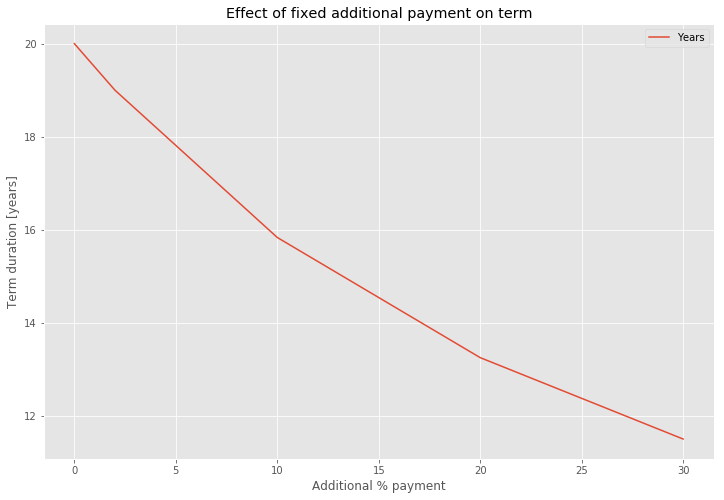

In [52]:
figsize(12,8)
fig, ax = plt.subplots(1, 1)
dfstats.plot(x='Additional % payment', y='Years', ax=ax)
plt.title("Effect of fixed additional payment on term");
plt.ylabel("Term duration [years]");


The next graph shows the total money repaid on the contract as a function of additional payment.  

If no additional payment is made, the total amount paid back over the full term of the contract is 2.16 times the initial loan principal amount.

Notice how the interest dramatically reduces if a fixed additional payment is made. 
If you pay 30% extra over and above the required payment, the total amount paid back over the full term of the contract is 1.6 times the initial loan principal amount.

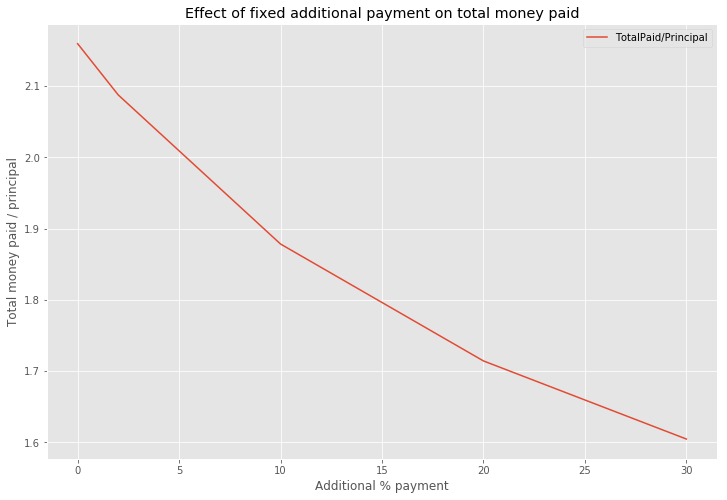

In [53]:
figsize(12,8)
fig, ax = plt.subplots(1, 1)
dfstats.plot(x='Additional % payment', y='TotalPaid/Principal', ax=ax)
plt.title("Effect of fixed additional payment on total money paid");
plt.ylabel("Total money paid / principal");


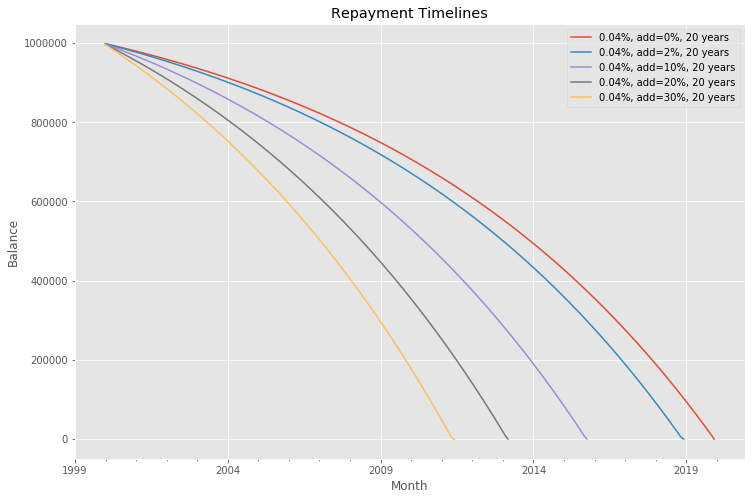

In [54]:
ufun.plot_amort_balance(schedules,scenarios)

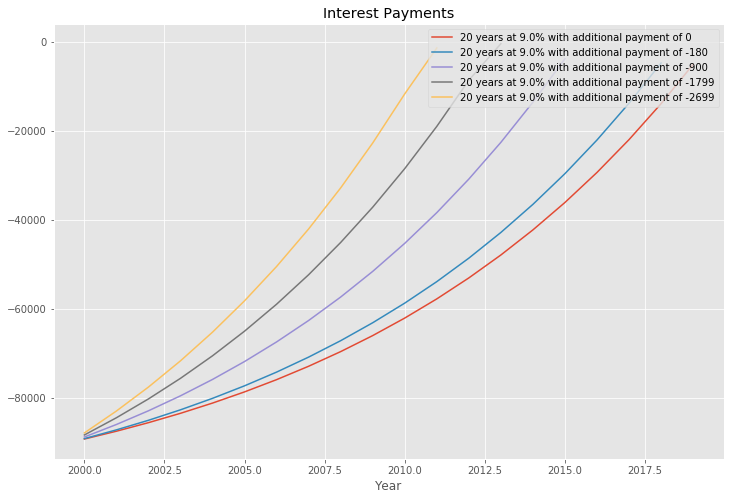

In [55]:
ufun.plot_amort_annual_interest(schedules,scenarios, stats)   

## Tax savings vs loan duration

Is it worth borrowing money for an investment property with the objective of writing interest off against tax?
It would seem to make sense to invest some cash and then take out a bond to cover the remainder of the purchase price.
The rent is an income and hence is taxable, however the bond interest is an expense and must be subtracted from the rent income before tax.
So in principle, it seems like a good idea to take out a bond and get the tax benefit on the interest.  In effect the tax man pays a portion of the interest.

This model increases the rent from a starting value only once per year.

Observe the effect of the number of years from 3 to 20, and the effect of changing the tax rate.

This analysis presently ignores the effect of time value of money.  



In [56]:
# bond values
principal = 500000
interest_rate = 0.09

# tax rate and rental income 
rentpmonth = 4500
increasepyear = 0.06

# experiment with variations
dfSch = pd.DataFrame()
dfSum = pd.DataFrame()

for bondyears in [3,5,10,20]:
    for taxrate in [0.2, 0.33, 0.42]:
        dfc,nistats = ufun.bondtaxsavingsanalysis(principal=principal,
                            interest_rate=interest_rate,bondyears=bondyears,
                            taxrate=taxrate,rentpmonth=rentpmonth,
                            increasepyear=increasepyear)
        # append all cases in to single df, must be filtered later
        dfSch = dfSch.append(dfc)
        # append all summaries into single df
        dfSum = dfSum.append(nistats,ignore_index=True)

The `dfSch` data frame contains all the month's status' for all the scenarios in one data frame.  To plot or analyse you must apply a filter to select only the required `NumPay` and `TaxRate` values.

In [57]:
drops = ['Month','InterestRate','Principal','ID']

if doLaTeXdisplay:
    display(Latex(dfSch.drop(drops,axis=1).round(2).head().to_latex(index=False,column_format=f'*{{{dfstats.shape[1]}}}{{|r}}|')))
    display(Latex(dfSch.drop(drops,axis=1).round(2).tail().to_latex(index=False,column_format=f'*{{{dfstats.shape[1]}}}{{|r}}|')))
else:
    display(HTML(dfSch.drop(drops,axis=1).round(2).head().to_html(index = False)))
    display(HTML(dfSch.drop(drops,axis=1).round(2).tail().to_html(index = False)))



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The following table shows the savings (BondBenefit) by claiming the interest back from tax:

In [58]:
# to compare different bond and tax rate scenarios
drops = ['AddPayment','Bond','IncomeNoInter','IncomeWithInter',
         'InitRent','ReqPayment','TaxNoInter','TaxWithInter','Total Rent','Interest Rate']
df = dfSum.drop(drops,axis=1)
df = df[['Num Payments','TaxRate','BondBenefit','Benefit/Rent %']]
# display(HTML(df.to_html(index=False)))
dfp = pd.pivot_table(df, index=['Num Payments'],values=['BondBenefit'],columns=['TaxRate'])

if doLaTeXdisplay:
    display(Latex(dfp.round(0).to_latex(index=True,column_format=f'|l*{{{dfp.shape[1]}}}{{|r}}|')))
else:
    display(HTML(dfp.round(0).to_html(index=True)))



<IPython.core.display.Latex object>

It seems that for bond periods of around 3 to 5 years, the savings benefit is only significant at high tax rates: the cost of setting up the bond may consume a substantial portion of the actual savings. As expected, at higher tax rates the income benefit is more. The savings expressed as percentage of rental income before tax and interest is not very high.

However, this calculation is not completely accurate:
1. To repay the bond over five years you need to pay a significant additional amount. There is a cost to this additional payment not accounted for this simple calculation.
1. The time value of money is not included here.

## Rental Property Analysis

Study the cash flow over some extended period `calcyears` when buying a property against a bonded loan for the purpose of renting it out. The loan can be fully repaid in `bondyears`, before the end of the extended study period. Hence in the initial `bondyears` the loan requires interest payment (as a cost against the property) and after the `bondyears` period, the interest is zero, with the property returning a positive inflow of cash.  The intent is to determine the effect of bond duration on the total cash flow over the extended period.

Given the loan amount, interest rate and other parameters, an additional payment is required to repay the loan at the end of the `bondyears` period. Hence, in the initial years the investment is cash flow negative as the loan is repaid.  The investment should become cash flow positive after the loan in repaid.  The question remains: over the extended analysis period, **what was the net cumulative cash flow?**  The smaller (or more negative) the net cumulative cash flow is, the poorer investment is.

For simplicity we assume that the additional loan down payment funds are free (no costs or losses in removing the funds from other investments).
We also assume that the tax is payable every month, whereas in real life, the tax is only payable on predetermined dates (once or twice per year).
The model allows for annual increase in rental income, rates and taxes, renting agency fees and levies. The tax benefit is also applied.

The model assumes that the rental income is paid towards depleting the bond (not removed as personal income).

The costs include: 
1. bond interest, cost of the loan, expressed as a percentage on outstanding balance.
1. maintenance, fix and maintain the property, expressed as percentage of rental income. Reasonable values should be 2% to 10% depending on the condition of the property. 
If it is a full-title property there should be no levies, but this maintenance cost should be higher.
If it is a sectional-title property there should be higher levies, but this maintenance cost should be lower, because much of the maintenance is already included in the levy.
1. renting agents fee (if applicable), expressed as percentage of rental income. It is convenient to use an agency to find renters and manage the rent agreement. Normally this is 7% to 10% of the rent.
1. levies (if applicable), if the property is part of a sectional title scheme.  This can also be used to include any costs to maintain buildings, gardens, etc.
1. Local government statutory rates and taxes.
1. risk of less than 100% occupancy, defaulting rent payments, damage to property, other other expenses arising from poor tenant behaviour.

**Note** the time value of money is not accounted for here, hence the situation is actually worse than what this analysis shows: we use expensive money to repay the loan early and earn cheap money positive cash flow later.

**Note** this analysis only considers the rental income and costs against this income.  The **capital growth is not considered at all in the present analysis**, it will be added later.

The calculation is as follows:

![](images/bond-optimisation.png)


**Note** The parameters used in the following investigation are not optimal in the sense that the rent income is poor relative to the cost of the property.
It may be possible to get half of this rent income (3000) for some properties costing a quarter of the value considered here (250k).



The parameters used in the analysis are as follows:

In [59]:
principal = 1000000
interest_rate = 0.097
bondyears = 5
calcyears = 20
rentpmonth = 7000
rentpermonthInc = 0.06
agentPcnt = 0.08
maintPcnt = 0.03
riskPcnt = 0.01
levy = -600
ratesnt = -600
levyInc = 0.06
ratesntInc = 0.06
taxrate = 0.33

dfc,istats = rfun.rentalProperty(principal=principal,interest_rate=interest_rate,
                bondyears=bondyears,calcyears=calcyears,rentpmonth=rentpmonth,rentpermonthInc=rentpermonthInc,
                agentPcnt=agentPcnt,levy=levy,ratesnt=ratesnt,levyInc=levyInc,
                ratesntInc=ratesntInc,maintPcnt=maintPcnt,taxrate=taxrate,riskPcnt=riskPcnt,doplot=False)

if doLaTeXdisplay:
    display(Latex(istats.to_frame().to_latex(index=True,column_format=f'|l*{{{istats.to_frame().shape[1]}}}{{r}}|')))
else:
    display(HTML(istats.to_frame().to_html(index=True)))


<IPython.core.display.Latex object>

### Monthly cash flow

The cash flow time line shows that  high costs (agent fees, maintenance, levies, rates and taxes) destroy the investment potential of property.  For effective investment return, you must bring down the costs dramatically.

The net monthly cash flow is negative while the bond is repaid, but positive afterwards.

Initially, the net rent after cost (including interest, but excluding payments against the principal) is negative, because the loan interest is very high. 



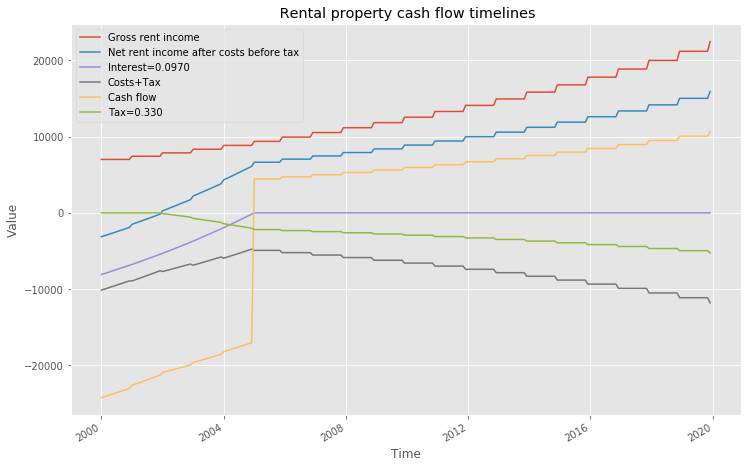

In [60]:
rfun.plotrentalpropcashflowtimeline(dfc)

Define the effective rent income as the fraction of the net rent income (after costs) to the gross rent income. With zero cost the effective rent income should be 1. Any costs will reduce this income to smaller than 1. We answer the question:  after costs, what is the net inflow from the investment?

In this graph, costs are defined as all outflows against the rental property, including bonded loan interest, agent's fees, levies, rates and taxes and maintenance.
This value does not include income tax in the hands of the investor or the down payment against the loan capital or principal. 

In the graph below the loan is repaid after five years and the interest is zero.

The graph title shows the mean value over the extended period of study. This value include the initial negative cash flow (interest), but excludes income tax and loan capital repayment.


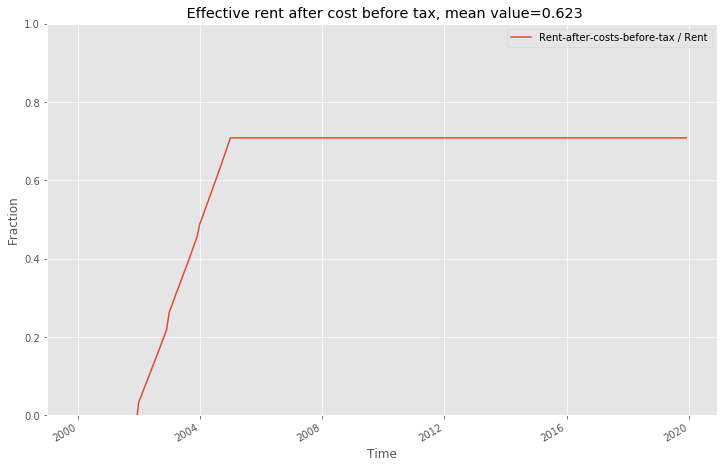

In [61]:
rfun.plotrentalpropeffectiverent(dfc)    

### Effect of income tax and  bonded loan duration 

Next investigate the effect of mortgage bond duration and tax rate on net cumulative cash flow over an extended period.
If you buy a property, which mortgage bond duration will give the best net cash flow over an extended period?   
How much does the cash flow differ for different bond  durations?  

The model considers the cumulative cash flow over a 20-year duration, of which the bond duration is the first $n$ years.  The principal amount, interest rate, the rent and all other costs are the same in all cases, only the bond payment duration varies.

The table below shows the scenario parameters for the results shown further down below:

In [62]:
principal = 1000000
interest_rate = 0.097
calcyears = 20
rentpmonth = 7000
rentpermonthInc = 0.06
agentPcnt = 0.08
maintPcnt = 0.03
riskPcnt = 0.01
levy = -600
ratesnt = -600
levyInc = 0.06
ratesntInc = 0.06

dfSum = pd.DataFrame()

for bondyears in [3, 4,5,7,10,20]:
    for taxrate in [0.2, 0.33, 0.42]:
        dfc,istats = rfun.rentalProperty(principal=principal,interest_rate=interest_rate,
                bondyears=bondyears,calcyears=calcyears,rentpmonth=rentpmonth,rentpermonthInc=rentpermonthInc,
                agentPcnt=agentPcnt,levy=levy,ratesnt=ratesnt,levyInc=levyInc,
                ratesntInc=ratesntInc,maintPcnt=maintPcnt,taxrate=taxrate,riskPcnt=riskPcnt,doplot=False)

        # append all summaries into single df
        dfSum = dfSum.append(istats,ignore_index=True)

istatsfiltex = istats[['Bond','Interest Rate','CalcYears','InitRent','RentIncrease','InitLevy',
                    'LevyIncrease','InitRandT','RandTIncrease','AgentPcnt','MaintPcnt','RiskPcnt']]

if doLaTeXdisplay:
    display(Latex(istatsfiltex.to_frame().to_latex(index=True,column_format=f'|l*{{{istatsfiltex.to_frame().shape[1]}}}{{r}}|')))
else:
    display(HTML(istatsfiltex.to_frame().to_html(index=True)))

<IPython.core.display.Latex object>

###  Net cumulative cash flow

The table shows the net cumulative cash flow (sum of cash flow over the extended period `CalcYears` od 20 years) as a function of bond pay-back period and tax rate.

It is clear that a 42% tax rate requires that the bond be paid off in three years in order to achieve a  positive net cumulative cash flow *only after 20 years*.
In this case the investment has only paid back the loan money but has not yet given any other income.

At a 20% tax rate the investment provides positive net cumulative cash flow after 20 years for a bond paid off in less than seven years.
At this tax rate, if you repaid the bond in four years, the investment will return about 400k net cash flow after 20 years.

At a 33% tax rate the investment provides positive net cumulative cash flow after 20 years for a bond paid off in less than four years.

Tax and *all* of the other 'cost' items contribute to this performance: the conclusion is that all costs must be minimised to make the investment worthwhile in terms of net cumulative cash flow after 20 years.


In [63]:
dft = pd.pivot_table(dfSum, index=['BondYears'],values=['CumCashFlow'],columns=['TaxRate'])
if doLaTeXdisplay:
    display(Latex(dft.to_latex(index=True,column_format=f'|l*{{{dft.shape[1]}}}{{|r}}|')))
else:
    display(HTML(dft.to_html(index=True)))


<IPython.core.display.Latex object>

### Effective rent after cost before tax

The following table shows the net rent income after costs (including interest) before income tax (also excluding the repayment of the loan capital).

It is evident for the property considered here, the longer term loan durations spends most of the rental income to repay the bond.

The data in the table is shown further down in graph format, when comparing with alternative investment options.

In [64]:
dfer = pd.pivot_table(dfSum, index=['BondYears'],values=['RentAfterCostsB4TaxFrac'],columns=['TaxRate'])
if doLaTeXdisplay:
    display(Latex(dfer.to_latex(index=True,column_format=f'|l*{{{dfer.shape[1]}}}{{|r}}|')))
else:
    display(HTML(dfer.to_html(index=True)))

<IPython.core.display.Latex object>

### Alternative, lower cost investment analysis

Consider less expensive property with lower rental income, but where the rent is relatively higher compared to the price of the property.

Consider a property at a quarter of the purchase cost of the property considered above, but where the property raises 3000 rental income.
In order to keep the same loan amount, four properties are bought and considered as a collective in this analysis.

The risk of damages in cheaper properties is higher than for the more expensive investment.  
How much higher must the risk be for similar returns as on the expensive property?
We consider a reasonable risk value 10% of rent, and the threshold value (26% for these scenarios) where the more expensive property is the better investment.


In [65]:
principal = 4 * 250000
interest_rate = 0.097
calcyears = 20
rentpmonth = 4 * 3000
rentpermonthInc = 0.06
agentPcnt = 0.08
maintPcnt = 0.03
riskPcnts = [0.1, 0.26]
levy = -4 * 400
ratesnt = -4 * 250
levyInc = 0.06
ratesntInc = 0.06

dfSum2 = pd.DataFrame()

for riskPcnt in riskPcnts:
    for bondyears in [3, 4,5,7,10,20]:
        for taxrate in [0.2, 0.33, 0.42]:
            dfc,istats = rfun.rentalProperty(principal=principal,interest_rate=interest_rate,
                    bondyears=bondyears,calcyears=calcyears,rentpmonth=rentpmonth,rentpermonthInc=rentpermonthInc,
                    agentPcnt=agentPcnt,levy=levy,ratesnt=ratesnt,levyInc=levyInc,
                    ratesntInc=ratesntInc,maintPcnt=maintPcnt,taxrate=taxrate,riskPcnt=riskPcnt,doplot=False)

            # append all summaries into single df
            dfSum2 = dfSum2.append(istats,ignore_index=True)


In [66]:
istatsfilt = istats[['Bond','Interest Rate','CalcYears','InitRent','RentIncrease','InitLevy',
                    'LevyIncrease','InitRandT','RandTIncrease','AgentPcnt','MaintPcnt']]

if doLaTeXdisplay:
    display(Latex(istatsfilt.to_frame().to_latex(index=True,column_format=f'|l*{{{istatsfilt.to_frame().shape[1]}}}{{|r}}|')))
else:
    display(HTML(istatsfilt.to_frame().to_html(index=True)))

<IPython.core.display.Latex object>

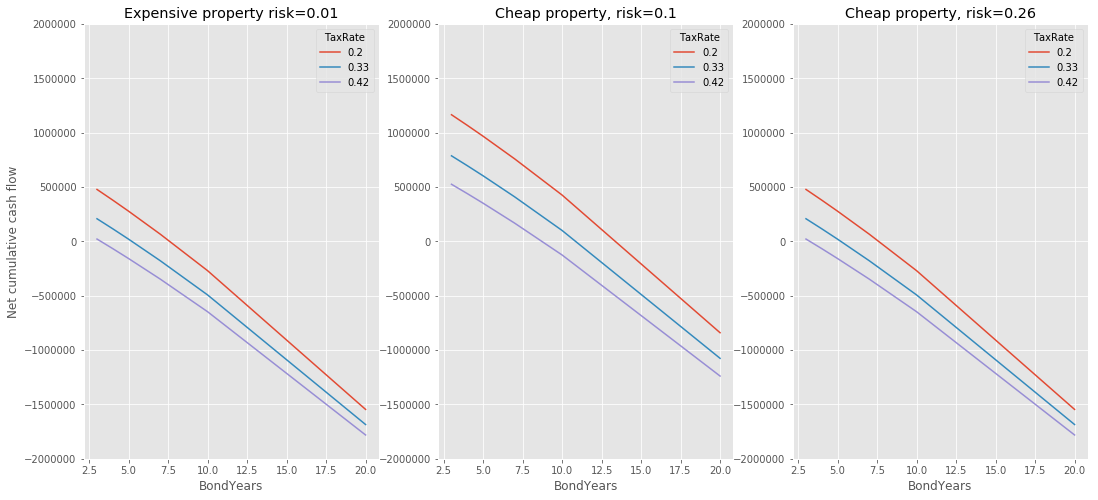

In [67]:
dftc = {}
for i,riskPcnt in enumerate(riskPcnts):
    dftc[i] = pd.pivot_table(dfSum2.loc[dfSum2['RiskPcnt']==riskPcnts[i]], 
                             index=['BondYears'],values=['CumCashFlow'],columns=['TaxRate'])
import matplotlib.pyplot as plt
figsize(18,8)
fig, axes = plt.subplots(nrows=1, ncols=3)
dft.reset_index().plot(x='BondYears',y='CumCashFlow',  ax=axes[0],ylim=[-2e6,2e6])    
axes[0].set_ylabel("Net cumulative cash flow");
axes[0].set_title(f"Expensive property risk={istatsfiltex['RiskPcnt']}");

for i,riskPcnt in enumerate(riskPcnts):
    dftc[i].reset_index().plot(x='BondYears',y='CumCashFlow',  ax=axes[i+1],ylim=[-2e6,2e6])      
    axes[i+1].set_title(f"Cheap property, risk={riskPcnt}");

The above analysis shows that for the scenarios considered, if the risk is higher than 26% of rent, the more expensive property is the better investment.
This is however, quite a high risk, it should be lower in a well managed portfolio.

The graphs show that at 10% risk, the less expensive property performs somewhat more than twice as good as the more expensive property.

In conclusion, if you are able and willing to manage the risks down low, the less expensive properties are considerable better investments than the more expensive property.
If the risks are higher or you don't want the trouble of managing risk and trouble the more expensive property still remains an option (less attractive though), especially if you do not operate the properties as a large scale business.

Finally, it seems that unless you tightly manage the costs and risks the cost of a rental investment, in terms of rental income only (ignoring capital growth) is of the same order as the costs of managed investments such as unit trusts (managed investments). If the management fee of a  unit trust is around 2% of fund value, the investor loses about 40% of the potential growth of the investment (details to follow).


Keep in mind that capital growth is not yet factored into this analysis.

## Moving funds between bonds 

### The scenario

Suppose I need to raise some money to buy a third property but a mortgage bond is not desired because the money must be paid back in a short time.  It was shown above that for shorter-term loans, the statutory and legal costs of obtaining the bond minimise the tax savings benefit on interest.

There are two existing mortgage bonds against which money can be drawn against (known as Access Bonds). The funds available for withdrawal in the access bond is equal to the *additional* money previously deposited (using the loan account as a 'savings' account).
The two properties under bond raise rent income, hence the interest can be claimed against tax.  The final objective is to repay the mortgage bonds in four years. How much money must be drawn from the different mortgage bonds to raise the new money for the lowest total cost? To repay all three bonds in the required time, how much additional payment must be made in each mortgage bond?

This is a classical minimisation problem, which can be solved by many different techniques.  The present calculation manually allocated the required 'new' funds to the two existing bonds up to the limit these bonds can supply.

The parameters for the three properties are shown in the dictionary below.  The principal amount for property PropertyV is made equal to 0 in order to make the functions work, but essentially is zero, hence also with zero interest costs.

In [68]:

sources = {
'PropertyK':{'principal':950000, 'interest_rate':0.0915,'rentpmonth':11395,'agentPcnt':0.12,'levy':0,'ratesnt':837,} ,   
'PropertyB':{'principal':610000, 'interest_rate':0.097,'rentpmonth':6500,'agentPcnt':0.09,'levy':983,'ratesnt':653,} ,   
'PropertyV':{'principal':1, 'interest_rate':0.001,'rentpmonth':7000,'agentPcnt':0.09,'levy':585,'ratesnt':650,}    
}

bondyears = 4
calcyears = 4
rentpermonthInc = 0.06
maintPcnt = 0.03
riskPcnt = 0.02
levyInc = 0.06
ratesntInc = 0.06
taxs = [0.2, 0.33, 0.42]
taxselect = 1

dfSum = pd.DataFrame()
df = pd.DataFrame()

for i,key in enumerate(sources.keys()):
    s = sources[key]
    for taxrate in taxs:
        dfc,istats = rfun.rentalProperty(principal=s['principal'],interest_rate=s['interest_rate'],
                bondyears=bondyears,calcyears=calcyears,rentpmonth=s['rentpmonth'],rentpermonthInc=rentpermonthInc,
                agentPcnt=s['agentPcnt'],levy=s['levy'],ratesnt=s['ratesnt'],levyInc=levyInc,
                ratesntInc=ratesntInc,maintPcnt=maintPcnt,taxrate=taxrate,riskPcnt=riskPcnt,doplot=False,
                ID=key)
        
        df = df.append(dfc,sort=True)
        dfSum = dfSum.append(istats,ignore_index=True)

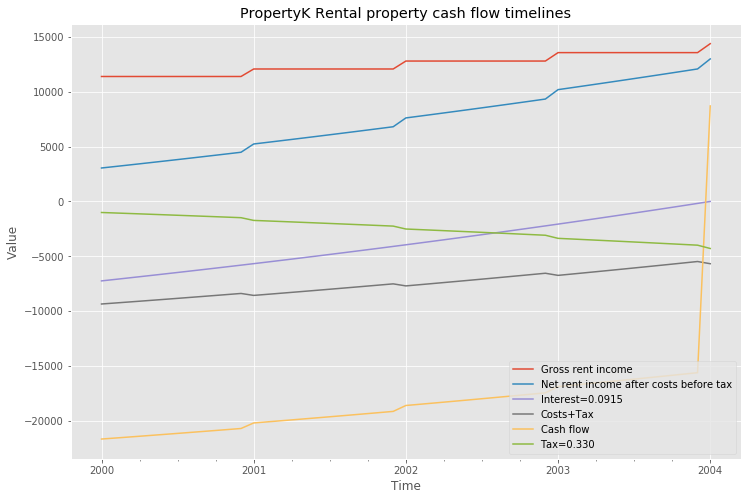

In [69]:
dfs = df.loc[(df['Principal'] == sources['PropertyK']['principal']) & (df['TaxRate'] == taxs[taxselect])]
rfun.plotrentalpropcashflowtimeline(dfs)

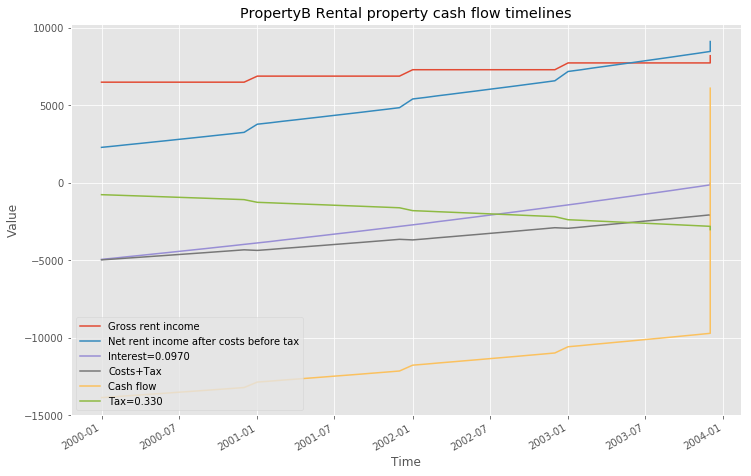

In [70]:
dfs = df.loc[(df['Principal'] == sources['PropertyB']['principal']) & (df['TaxRate'] == taxs[taxselect])]
rfun.plotrentalpropcashflowtimeline(dfs)

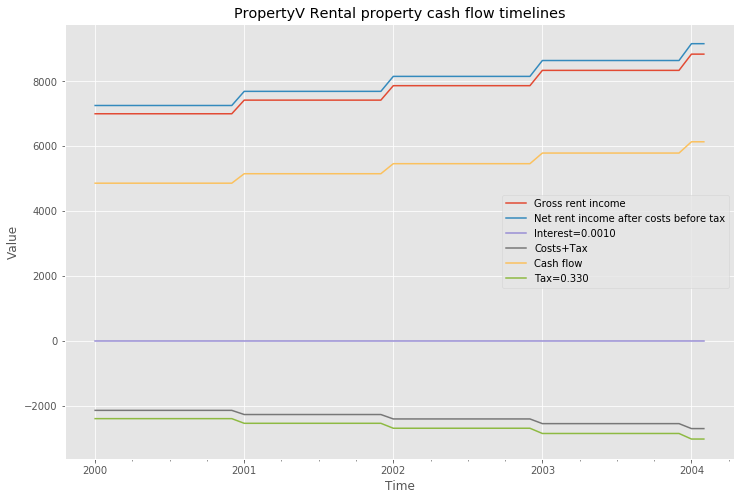

In [71]:
dfs = df.loc[(df['Principal'] == sources['PropertyV']['principal']) & (df['TaxRate'] == taxs[taxselect])]
rfun.plotrentalpropcashflowtimeline(dfs)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

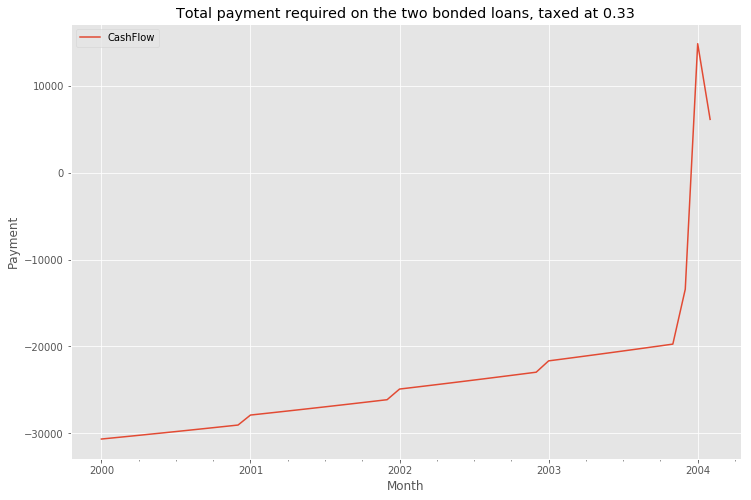

In [77]:
# to calculate the sum of all cash flow values available for each month
# do this for one value of tax rate
dfsum = pd.pivot_table(df.loc[df['TaxRate'] == taxs[taxselect]], 
                             index=['Month'],values=['CashFlow'],aggfunc=np.sum)
dfsum.reset_index(level=0, inplace=True)

if doLaTeXdisplay:
    display(Latex(dfsum.head().to_latex(index=True,column_format=f'|l*{{{dfsum.shape[1]}}}{{|r}}|')))
    display(Latex(dfsum.tail().to_latex(index=True,column_format=f'|l*{{{dfsum.shape[1]}}}{{|r}}|')))
else:
    display(HTML(dfsum.head().to_html(index=True)))
    display(HTML(dfsum.tail().to_html(index=True)))

figsize(12,8)
fig, axes = plt.subplots(nrows=1, ncols=1)
dfsum.plot(x='Month',y='CashFlow',  ax=axes)    
axes.set_ylabel("Payment");
axes.set_title(f"Total payment required on the two bonded loans, taxed at {taxs[taxselect]}");

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

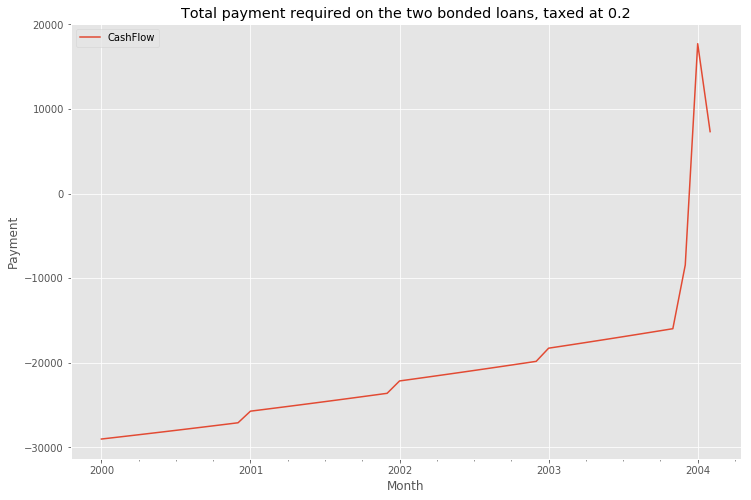

In [78]:
# to calculate the sum of all cash flow values available for each month
# do this for one value of tax rate
taxselect = 0
dfsum = pd.pivot_table(df.loc[df['TaxRate'] == taxs[taxselect]], 
                             index=['Month'],values=['CashFlow'],aggfunc=np.sum)
dfsum.reset_index(level=0, inplace=True)

if doLaTeXdisplay:
    display(Latex(dfsum.head().to_latex(index=True,column_format=f'|l*{{{dfsum.shape[1]}}}{{|r}}|')))
    display(Latex(dfsum.tail().to_latex(index=True,column_format=f'|l*{{{dfsum.shape[1]}}}{{|r}}|')))
else:
    display(HTML(dfsum.head().to_html(index=True)))
    display(HTML(dfsum.tail().to_html(index=True)))

figsize(12,8)
fig, axes = plt.subplots(nrows=1, ncols=1)
dfsum.plot(x='Month',y='CashFlow',  ax=axes)    
axes.set_ylabel("Payment");
axes.set_title(f"Total payment required on the two bonded loans, taxed at {taxs[taxselect]}");

## Python and [module versions, and dates](https://github.com/rasbt/watermark)

In [73]:
# to get software versions
# https://github.com/rasbt/watermark
# https://github.com/rasbt/watermark/blob/master/docs/watermark.ipynb
# you only need to do this once
# pip install watermark
# conda install -c conda-forge watermark

%load_ext watermark
%watermark -v -m -p numpy,scipy -g 

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
scipy 1.1.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : c79dec25ffb2d3ed1d5d443ee84cb0e171165a8a
